# Bioenergy from Eurostat's SHARES database

Data from the tsv tables accessed from the [Energy database](https://ec.europa.eu/eurostat/web/energy/data/database) under energy indicators as 'Share of energy from renewable sources until 2020' (nrg_ind_share). Three tsv tables for each sector (electricity, heating and cooling, transport).
* Use of renewables for transport - details (nrg_ind_urtd)
* Use of renewables for electricity - details (nrg_ind_ured)
* Use of renewables for heating and cooling - details (nrg_ind_urhcd)

One of the output csv files is a tidier version of the Eurostat data.

Very helpful are [Standard international energy product classification (SIEC)](http://dd.eionet.europa.eu/vocabulary/eurostat/siec/) vocabulary and [Energy balance](http://dd.eionet.europa.eu/vocabulary/eurostat/nrg_bal/) vocabulary.

## Fuels
Biomass-based fuels I cover here (SIEC codes in brackets):
* Primary solid biofuels (R5110-5150_W6000RI)
* Biogases (R5300)
* Liquid biofuels (R5200)
* Renewable municipal waste (W6210)

Other fuels we care about:
* Renewables and biofuels (RA000)
* Total (TOTAL)

## Variables
If I understand it correctly in the SHARES database in the **electricity sector** I should look for 'Gross electricity generation' for biomass-based fuels, in the **heating sector** it seems as a sum of 'Final consumption in industry and others sectors' and 'Gross heat production' and in the **transport sector** the variables are probably 'Final consumption' variable for road, rail and other sectors.

Depending on the sector (electricity, heating and cooling, transport) we are interested in the following variables:

### Electricity
* Gross electricity production - Renewable Energy Directive (GEP_RED)

### Heating and cooling
* Gross heat production - Renewable Energy Directive (GHP_RED)
* Final consumption - industry and other sectors - energy use (FC_IND_OTH_E)

### Transport
* Final consumption - other transport sector- energy use - Renewable Energy Directive (FC_TRA_OTH_E_RED)
* Final consumption - transport sector - road - energy use - Renewable Energy Directive (FC_TRA_ROAD_E_RED)
* Final consumption - transport sector - rail - energy use - Renewable Energy Directive (FC_TRA_RAIL_E_RED)

Disclaimer: I might got something wrong. I still have to go through the whole [Energy balance guide](https://ec.europa.eu/eurostat/documents/38154/4956218/ENERGY-BALANCE-GUIDE-DRAFT-31JANUARY2019.pdf/cf121393-919f-4b84-9059-cdf0f69ec045).



In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def tidy_it(df, csv_name):
    """Tidy the dataset, return it and output to a csv file"""
    # Year as a variable 
    df = df.melt(['siec', 'nrg_bal', 'unit', 'geo'], var_name='year')

    # Moving variables in nrg_bal column in the source from rows to individual columns
    df.set_index(['geo', 'year', 'siec', 'unit', 'nrg_bal'], inplace=True)
    df = df.unstack()
    # https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns
    df.columns = df.columns.get_level_values(1)
    df.columns.name = None
    df = df.reset_index()
    # All fuels and variables for electricity but tidy
    df.to_csv(os.path.join(os.path.abspath(csv_output_dir), csv_name), decimal=',', index_label='id')
    return df

In [2]:
csv_output_dir = 'eu_tidy'

if not os.path.exists(csv_output_dir):
    os.mkdir(csv_output_dir)

In [3]:
# Standard international energy product classification (SIEC)
# https://dd.eionet.europa.eu
# Download the siec.csv
# http://dd.eionet.europa.eu/vocabulary/eurostat/siec/csv
# Dictionary from siec codes to human readable labels
siec = pd.read_csv('siec.csv')
siec
fuels_dict = {k: v for k, v in zip(siec['Label'], siec['Notation'])}

In [4]:
# We are interested in renewables and bioenergy
selected_fuels = [
    'Total',
    'Renewables and biofuels',
    'Primary solid biofuels',
    'Biogases',
    'Liquid biofuels',
    'Renewable municipal waste',
    ]

selected_bio_fuels = [
    'Primary solid biofuels',
    'Biogases',
    'Liquid biofuels',
    'Renewable municipal waste',
    ]

selected_fuel_codes = [v for k,v in fuels_dict.items() if k in selected_fuels]
selected_bio_codes = [v for k,v in fuels_dict.items() if k in selected_bio_fuels]

In [5]:
print(selected_fuel_codes, selected_bio_codes)


['TOTAL', 'RA000', 'R5110-5150_W6000RI', 'R5200', 'R5300', 'W6210'] ['R5110-5150_W6000RI', 'R5200', 'R5300', 'W6210']


## Electricity

In [6]:
# The source tsv file is hybrid with tabs and commas as separators
el = pd.read_table('nrg_ind_ured.tsv', delimiter='[\t,]+')
el.rename(columns={'geo\\time': 'geo'}, inplace=True)
# Some column names have additional whitespace
el.rename(columns={str(year) + ' ': year for year in range(2004, 2019)}, inplace=True)
el.rename(columns={'2004': 2004}, inplace=True)

In [7]:
el = tidy_it(el, 'shares_electricity_tidy.csv')

el.head()

,geo,year,siec,unit,GEP_NPUMP_MIX,GEP_RED,GFC_ELC,NMLPRD_MIX,NMLPRD_PURE
0,AL,2004,E7000,GWH,0.0,NaN,NaN,0.0,4256.8
1,AL,2004,R5110-5150_W6000RI,GWH,NaN,0.0,NaN,NaN,NaN
2,AL,2004,R5292P,GWH,NaN,0.0,NaN,NaN,NaN
3,AL,2004,R5292SB,GWH,NaN,0.0,NaN,NaN,NaN
4,AL,2004,R5292SP,GWH,NaN,0.0,NaN,NaN,NaN


In [8]:
needed_fuels = el['siec'].str.fullmatch('|'.join(selected_fuel_codes))
bio_fuels = el['siec'].str.fullmatch('|'.join(selected_bio_codes))

In [9]:
# Aggregate (sum) GEP_RED for biomass fuels for all countries for each year
gep_bio_gwh = el[bio_fuels].pivot_table(values='GEP_RED', index='year', columns='geo', aggfunc='sum')
gep_bio_ktoe = gep_bio_gwh * 3.6 / 41.868
gep_bio_tj = gep_bio_gwh * 3.6 
    
gep_bio_gwh.to_csv(os.path.join(os.path.abspath(csv_output_dir), 'gep_bio_gwh.csv'), decimal=',')
gep_bio_ktoe.to_csv(os.path.join(os.path.abspath(csv_output_dir), 'gep_bio_ktoe.csv'), decimal=',')
gep_bio_tj.to_csv(os.path.join(os.path.abspath(csv_output_dir), 'gep_bio_tj.csv'), decimal=',')

gep_bio_gwh

geo,AL,AT,BA,BE,BG,CY,CZ,DE,DK,EA19,...,PL,PT,RO,RS,SE,SI,SK,TR,UK,XK
year,,,,,,,,,,,,,,,,,,,,,
2004,0.0,1890.439,0.0,1037.889,0.000,0.000,713.371,10499.0,2907.000,39691.173,...,982.744,1541.930,4.000,0.000,7165.352,120.774,20.000,76.000,7355.149,0.0
2005,0.0,2378.382,0.0,1509.042,0.000,0.000,731.721,14592.0,3173.000,44725.361,...,1511.127,1680.693,6.000,0.000,7424.936,113.723,32.000,34.000,9103.299,0.0
2006,0.0,3167.129,0.0,1999.398,0.000,0.155,918.167,18217.0,3068.000,51587.651,...,1992.790,1704.994,4.453,0.000,8117.035,110.255,398.314,57.850,9277.875,0.0
2007,0.0,3987.533,0.0,2403.467,0.000,1.437,1195.259,23669.0,3104.000,58795.855,...,2555.574,1863.947,35.996,0.000,9669.000,113.154,474.000,94.942,9325.501,0.0
2008,0.0,4122.230,0.0,3187.450,15.532,11.540,1449.079,26928.0,3139.000,65763.765,...,3618.232,1852.457,23.881,0.000,10230.994,288.315,517.000,142.295,9567.237,0.0
2009,0.0,4236.650,0.0,3589.345,7.402,26.518,1848.464,29253.0,3319.000,69425.093,...,5223.353,2085.791,10.539,0.000,11185.410,188.272,537.000,251.651,10715.323,0.0
2010,0.0,4450.398,0.0,4061.780,35.239,35.124,2162.487,32646.0,4593.087,79006.738,...,6303.590,2613.689,110.490,0.000,12011.900,216.877,662.000,332.904,12262.260,0.0
2011,0.0,4547.755,0.0,4475.572,55.737,51.610,2703.475,36508.0,4374.861,87346.796,...,7599.511,2923.545,196.690,0.000,11534.000,251.752,819.000,342.841,13314.025,0.0
2012,0.0,4678.700,0.0,5053.077,65.827,49.819,3371.706,42957.0,4445.952,97155.897,...,10094.050,2950.655,211.689,6.000,12189.000,267.290,941.000,591.932,14734.837,0.0


<AxesSubplot:title={'center':'Bioelectricity EU27'}, xlabel='year', ylabel='Gross electricity production (GWh)'>

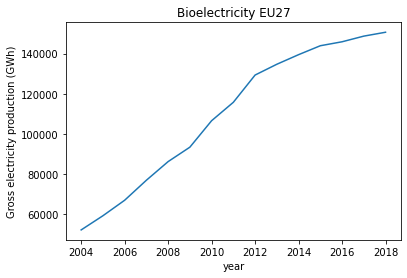

In [10]:
gep_bio_gwh['EU27_2020'].plot(title='Bioelectricity EU27', ylabel='Gross electricity production (GWh)', xlabel='year')

## Heating and cooling sector

In [11]:
hc = pd.read_table('nrg_ind_urhcd.tsv', delimiter='[\t,]+')
hc.rename(columns={'geo\\time': 'geo'}, inplace=True)
hc.rename(columns={str(year) + ' ': year for year in range(2004, 2019)}, inplace=True)
hc.rename(columns={'2004': 2004}, inplace=True)

for col in range(2004,2019):
    hc[col] = pd.to_numeric(hc[col], errors='coerce')

In [12]:
# Tidying the dataset

hc = tidy_it(hc, 'shares_heat_tidy.csv')

hc.head()

,geo,year,siec,unit,BIOG_G_ADJSHR,BIOG_G_SHR,BIOG_G_TRA,FC_IND_OTH_E,GFC_HEAT_CL_E,GHP_RED,PPRD_RED
0,AL,2004,R5110-5150_W6000RI,KTOE,NaN,NaN,NaN,233.018,NaN,0.0,NaN
1,AL,2004,R5160,KTOE,NaN,NaN,NaN,0.000,NaN,NaN,NaN
2,AL,2004,R5292,KTOE,NaN,NaN,NaN,0.000,NaN,NaN,NaN
3,AL,2004,R5292P,KTOE,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,AL,2004,R5292S,KTOE,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
needed_fuels = hc['siec'].str.fullmatch('|'.join(selected_fuel_codes))
bio_fuels = hc['siec'].str.fullmatch('|'.join(selected_bio_codes))


In [14]:
# Aggregate (sum) GHP_RED and FC_IND_OTH_E for biomass fuels for all countries for each year

ghp = hc[bio_fuels].pivot_table(values='GHP_RED', index='year', columns='geo', aggfunc='sum')
fc = hc[bio_fuels].pivot_table(values='FC_IND_OTH_E', index='year', columns='geo', aggfunc='sum')

ghpfc_bio_ktoe = ghp + fc
ghpfc_bio_tj = ghpfc_bio_ktoe * 3.6 

ghpfc_bio_ktoe.to_csv(os.path.join(os.path.abspath(csv_output_dir), 'ghpfc_bio_ktoe.csv'), decimal=',')
ghpfc_bio_tj.to_csv(os.path.join(os.path.abspath(csv_output_dir), 'ghpfc_bio_tj.csv'), decimal=',')

ghpfc_bio_ktoe

geo,AL,AT,BA,BE,BG,CY,CZ,DE,DK,EA19,...,PL,PT,RO,RS,SE,SI,SK,TR,UK,XK
year,,,,,,,,,,,,,,,,,,,,,
2004,233.018,2587.203,182.072,587.464,708.942,4.490,1660.672,7780.453,1573.994,39282.008,...,3935.633,2479.674,3078.293,802.522,6559.783,439.715,344.989,5530.787,482.326,216.299
2005,230.032,2970.871,181.738,674.859,691.315,2.293,1724.586,8130.267,1734.188,41376.655,...,3856.095,2505.207,3183.672,802.522,7013.017,448.983,360.203,5323.899,476.044,216.299
2006,230.032,3188.653,181.499,712.860,735.956,3.344,1779.808,9138.507,1812.937,43294.439,...,3935.846,2521.592,3101.223,802.355,7323.039,429.421,311.671,5126.039,517.030,216.299
2007,214.985,3400.876,181.212,809.355,675.456,5.923,1848.070,9941.721,2016.600,46465.856,...,3920.177,2562.339,3233.735,801.949,7548.677,416.978,409.166,4986.864,580.921,216.323
2008,215.081,3507.179,180.042,946.665,750.549,10.008,1901.356,10864.550,2079.488,49214.624,...,4011.942,2555.651,3796.527,804.242,7524.361,413.418,399.183,4759.076,1217.112,233.114
2009,209.993,3579.236,179.851,1027.348,739.968,21.209,2002.699,10547.005,2120.283,49230.768,...,4159.167,2541.702,3755.684,1055.221,7638.674,583.143,513.639,4580.538,1304.528,234.714
2010,205.001,4029.838,179.253,1165.973,885.880,17.483,2098.164,12800.445,2407.420,53164.347,...,4608.270,2150.879,3944.468,1026.607,8385.260,601.224,536.854,4440.121,1624.749,236.338
2011,208.011,3927.683,178.967,1129.168,946.810,20.660,2162.057,12004.180,2316.364,48825.448,...,4880.243,2161.651,3481.896,1022.070,7939.738,597.592,552.307,3539.935,1525.508,241.951
2012,206.506,4107.815,178.824,1271.306,1007.691,18.534,2285.946,13352.967,2345.785,53999.562,...,5016.791,1756.688,3665.997,1024.577,8472.986,577.147,519.370,3477.859,1765.215,247.492


<AxesSubplot:title={'center':'Bioheat EU27'}, xlabel='year', ylabel='Gross heat production and final cosumption (TJ)'>

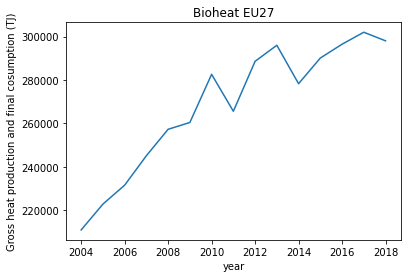

In [15]:
ghpfc_bio_tj['EU27_2020'].plot(title='Bioheat EU27', ylabel='Gross heat production and final cosumption (TJ)', xlabel='year')

## Transport

In [16]:
tr = pd.read_table('nrg_ind_urtd.tsv', delimiter='[\t,]+')
tr.rename(columns={'geo\\time': 'geo'}, inplace=True)
tr.rename(columns={str(year) + ' ': year for year in range(2004, 2019)}, inplace=True)
tr.rename(columns={'2004': 2004}, inplace=True)

for col in range(2004,2019):
    tr[col] = pd.to_numeric(tr[col], errors='coerce')

In [17]:
# Tidy it
tr = tidy_it(tr, 'shares_transport_tidy.csv')

tr.head()

,geo,year,siec,unit,BIOFCON_LIM_TRA,BIOF_FS_SHR,FC_TRA_E_RED,FC_TRA_OTH_E_RED,FC_TRA_RAIL_E_RED,FC_TRA_ROAD_E_RED,GFC_TRA_E_MULTI,GFC_TRA_E_NMULTI,LIM_TT,NRG_MNBRFT_E,ST_MS_TRA
0,AL,2004,E7000,KTOE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,AL,2004,E7100,KTOE,NaN,NaN,NaN,0.722,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,AL,2004,E7200,KTOE,NaN,NaN,NaN,0.310,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,AL,2004,R5200,KTOE,NaN,NaN,NaN,0.000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,AL,2004,R5200,PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
needed_fuels = tr['siec'].str.fullmatch('|'.join(selected_fuel_codes))
bio_fuels = tr['siec'].str.fullmatch('|'.join(selected_bio_codes))

In [19]:
# Agregate final consumtion accross road, rail and other sectors into new column
tr['fc_tra_all'] = tr.loc[:, ['FC_TRA_OTH_E_RED', 'FC_TRA_RAIL_E_RED', 'FC_TRA_ROAD_E_RED']].sum(axis=1)

In [20]:
# Aggregate (sum) GEP_RED for biomass fuels for all countries for each year
fct_bio_ktoe = tr[bio_fuels].pivot_table(values='fc_tra_all', index='year', columns='geo', aggfunc='sum')
fct_bio_tj = fct_bio_ktoe * 3.6 
    
fct_bio_ktoe.to_csv(os.path.join(os.path.abspath(csv_output_dir), 'fct_bio_ktoe.csv'), decimal=',')
fct_bio_tj.to_csv(os.path.join(os.path.abspath(csv_output_dir), 'fct_bio_tj.csv'), decimal=',')

fct_bio_ktoe

geo,AL,AT,BA,BE,BG,CY,CZ,DE,DK,EA19,...,PL,PT,RO,RS,SE,SI,SK,TR,UK,XK
year,,,,,,,,,,,,,,,,,,,,,
2004,0.000,0.000,0.0,0.000,0.000,0.000,0.000,907.973,0.000,1683.464,...,13.543,0.000,0.000,0.0,150.243,0.000,1.00,0.0,16.452,0.0
2005,0.000,73.767,0.0,0.000,0.000,0.000,0.000,1828.151,0.000,2945.828,...,49.664,0.000,0.000,0.0,166.257,0.000,11.17,0.0,68.765,0.0
2006,0.000,256.063,0.0,0.000,5.428,0.000,0.000,3343.699,3.826,4869.842,...,90.592,71.628,0.000,0.0,233.845,4.080,40.17,0.0,180.274,0.0
2007,0.000,322.095,0.0,0.000,2.323,0.000,0.000,3795.572,5.739,6784.091,...,96.699,121.876,0.000,0.0,308.778,13.769,59.49,0.0,348.951,0.0
2008,0.000,395.209,0.0,0.000,4.180,14.140,109.941,2971.506,5.102,7857.697,...,437.060,125.566,0.000,0.0,372.057,24.568,72.27,0.0,805.255,0.0
2009,0.000,511.115,0.0,132.023,3.747,15.023,194.779,2632.849,8.684,9053.048,...,635.888,208.095,0.000,0.0,395.306,29.687,84.45,0.0,988.163,0.0
2010,0.000,495.423,0.0,358.076,13.409,15.023,231.251,2897.800,26.784,10178.658,...,867.425,309.130,0.000,0.0,429.843,44.606,96.59,0.0,1150.334,0.0
2011,0.000,497.781,0.0,346.646,16.760,15.907,300.110,2844.810,130.489,10506.932,...,915.535,293.076,195.990,0.0,452.321,34.991,100.27,0.0,1063.649,0.0
2012,0.000,490.963,0.0,345.177,83.886,15.907,275.270,2968.806,226.605,11218.357,...,807.349,273.296,178.310,0.0,516.848,50.971,94.15,0.0,896.752,0.0


<AxesSubplot:title={'center':'Biotransport EU27'}, xlabel='year', ylabel='Final cosumption (TJ)'>

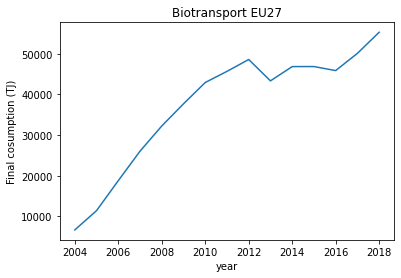

In [21]:
fct_bio_tj['EU27_2020'].plot(title='Biotransport EU27', ylabel='Final cosumption (TJ)', xlabel='year')

## Bioenergy (all sectors)

<AxesSubplot:title={'center':'Bioenergy'}, xlabel='year', ylabel=' Bioenergy from SHARES (ktoe)'>

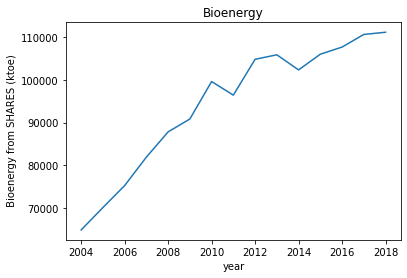

In [22]:
bioenergy = gep_bio_ktoe + ghpfc_bio_ktoe + fct_bio_ktoe

bioenergy_tj = bioenergy * 41.868

bioenergy.to_csv(os.path.join(os.path.abspath(csv_output_dir), 'bioenergy_ktoe.csv'), decimal=',')
bioenergy_tj.to_csv(os.path.join(os.path.abspath(csv_output_dir), 'bioenergy_tj.csv'), decimal=',')

bioenergy['EU27_2020'].plot(title='Bioenergy', ylabel=' Bioenergy from SHARES (ktoe)', xlabel='year')